### Analysis of Whatsapp Group Chat

In [1]:
import re
import math
import spacy
import importlib
import helpers
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm import tqdm
from collections import Counter
from zipfile import ZipFile
from plotly.subplots import make_subplots
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from vaderSentiment import vaderSentiment
from helpers import unzip_chat, extract_chat_data, preprocess_df

importlib.reload(helpers)
warnings.filterwarnings(action='ignore')

In [2]:
unzipped_data = unzip_chat("WhatsApp Chat with The Boys")
whatsapp_chat_data = extract_chat_data(unzipped_data)
whatsapp_df = preprocess_df(whatsapp_chat_data)
whatsapp_df['word_length'].mean()

4.114823857690967

In [3]:
group_members = whatsapp_df['sender'].unique()
group_members

array(['Big Sam', '+234 703 561 5807', '+234 704 047 6699', 'Daniel',
       'BFA', 'Jordan', '+2349049868222', 'Afeez', 'Tolu', 'Tmak',
       'Ridwan', 'D Bello', 'Faiz 😎', 'Nuel', 'Physics', 'CJ',
       'Nelson ICT', 'Egbebi', '', '+234 813 726 6749', 'agbo ICT',
       '+234 904 165 3101'], dtype=object)

In [125]:
# whatsapp_df['sender'].value_counts(ascending=True).plot(kind='barh');
fig = px.bar(whatsapp_df['sender'].value_counts().sort_values(ascending=False), orientation='v', title='Group members message count')
fig.update_layout(xaxis_title='Members', yaxis_title='No. of messages',)
fig.show();

In [338]:

time_order_dict = {
'day_order':['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
'month_order': ['June', 'July', 'August', 'September', 'October'],
'hour_order': ['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00']
}
freq_cols = ['month', 'day', 'hour']
fig = make_subplots(rows=len(freq_cols), cols=1, subplot_titles=[f"{col.capitalize()}ly Message frequency" for col in freq_cols])

for idx, col_name in enumerate(freq_cols):
    df_plot = whatsapp_df.groupby(col_name).size().reindex(time_order_dict[f"{col_name}_order"]).reset_index(name='count')
    trace = px.line(df_plot, x=col_name, y='count').data[0]
    fig.add_trace(trace, row=idx + 1,  col=1)
fig.update_layout(height=1000, title_text="Message Frequency Distributions")
fig.show()

In [38]:
fig = px.bar(whatsapp_df['day'].value_counts(ascending=True)[:10].reindex(time_order_dict['day_order']), title="Daily Message Frequency")
fig.update_layout({'yaxis_title':'No. of messages', 'showlegend': False})
fig.show()

In [196]:
message_length_df = whatsapp_df.groupby('sender')[['word_length', 'character_length']].mean().sort_values('word_length',ascending=False)
message_length_df
fig=px.bar(message_length_df, orientation='v', title='Avg. message length per group member')
fig.update_layout(xaxis_title="Group member", yaxis_title="Avg. message length")
fig.show()

In [204]:
print(f"The average group message contains {int(whatsapp_df['character_length'].mean())} characters and {int(whatsapp_df['word_length'].mean())} words")

The average group message contains 19 characters and 4 words


In [210]:
fig=px.histogram(whatsapp_df['word_length'], title='Message Length Distribution', nbins=30)
fig.update_layout(xaxis_title='Message Length');

In [212]:
upper_msg_len, lower_msg_len = whatsapp_df['word_length'].quantile(.9), whatsapp_df['word_length'].quantile(.1)
normalized_msg_len_df = whatsapp_df[(whatsapp_df['word_length']<=upper_msg_len) & (whatsapp_df['word_length']>=lower_msg_len)]
fig = px.histogram(normalized_msg_len_df['word_length'])
fig.update_layout({'xaxis_title':'Message Length', 'title':'Normalized word length dist.', 'showlegend':False})
fig.show()

In [215]:
print(f"The average time between responses is: {whatsapp_df['date_and_time'].diff().mean()}")

The average time between responses is: 0 days 00:11:21.004604437


In [471]:
nlp = spacy.load('en_core_web_md')
all_texts = ' '.join(whatsapp_df['message'])
tokens = word_tokenize(all_texts)
en_tokens = [t.lower() for t in tokens if t.isalpha() and t not in ENGLISH_STOP_WORDS and t not in ['message', 'edited']]
en_text = " ".join(en_tokens)
non_alpha_tokens = [t for t in tokens if not t.isalpha()]
non_alpha_text = " ".join(non_alpha_tokens)

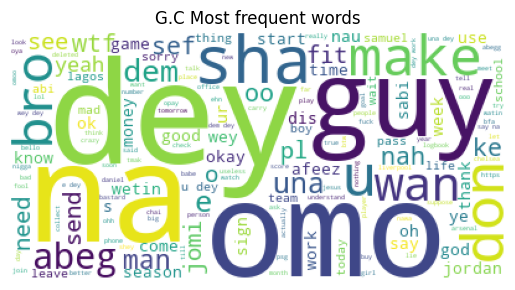

In [244]:
plt.imshow(WordCloud(background_color='white').generate(text=en_text))
plt.axis('off')
plt.title("G.C Most frequent words");

In [252]:
heatmap_df=whatsapp_df.groupby(['day', 'hour']).size().unstack(fill_value=0).reindex(time_order_dict["day_order"]).T
fig = px.imshow(heatmap_df.T, text_auto=True, title="Hourly group activity by days")
fig.update_layout(xaxis={'dtick': 1, 'tickangle':30})

In [254]:
heatmap_df = whatsapp_df.groupby(['part_of_day', 'sender']).size().unstack()
fig = px.imshow(heatmap_df, width=1000, height=500, text_auto=True, aspect='auto', title='Members activity')
fig.update_layout(xaxis_title='Daily activity by member')
fig.show()

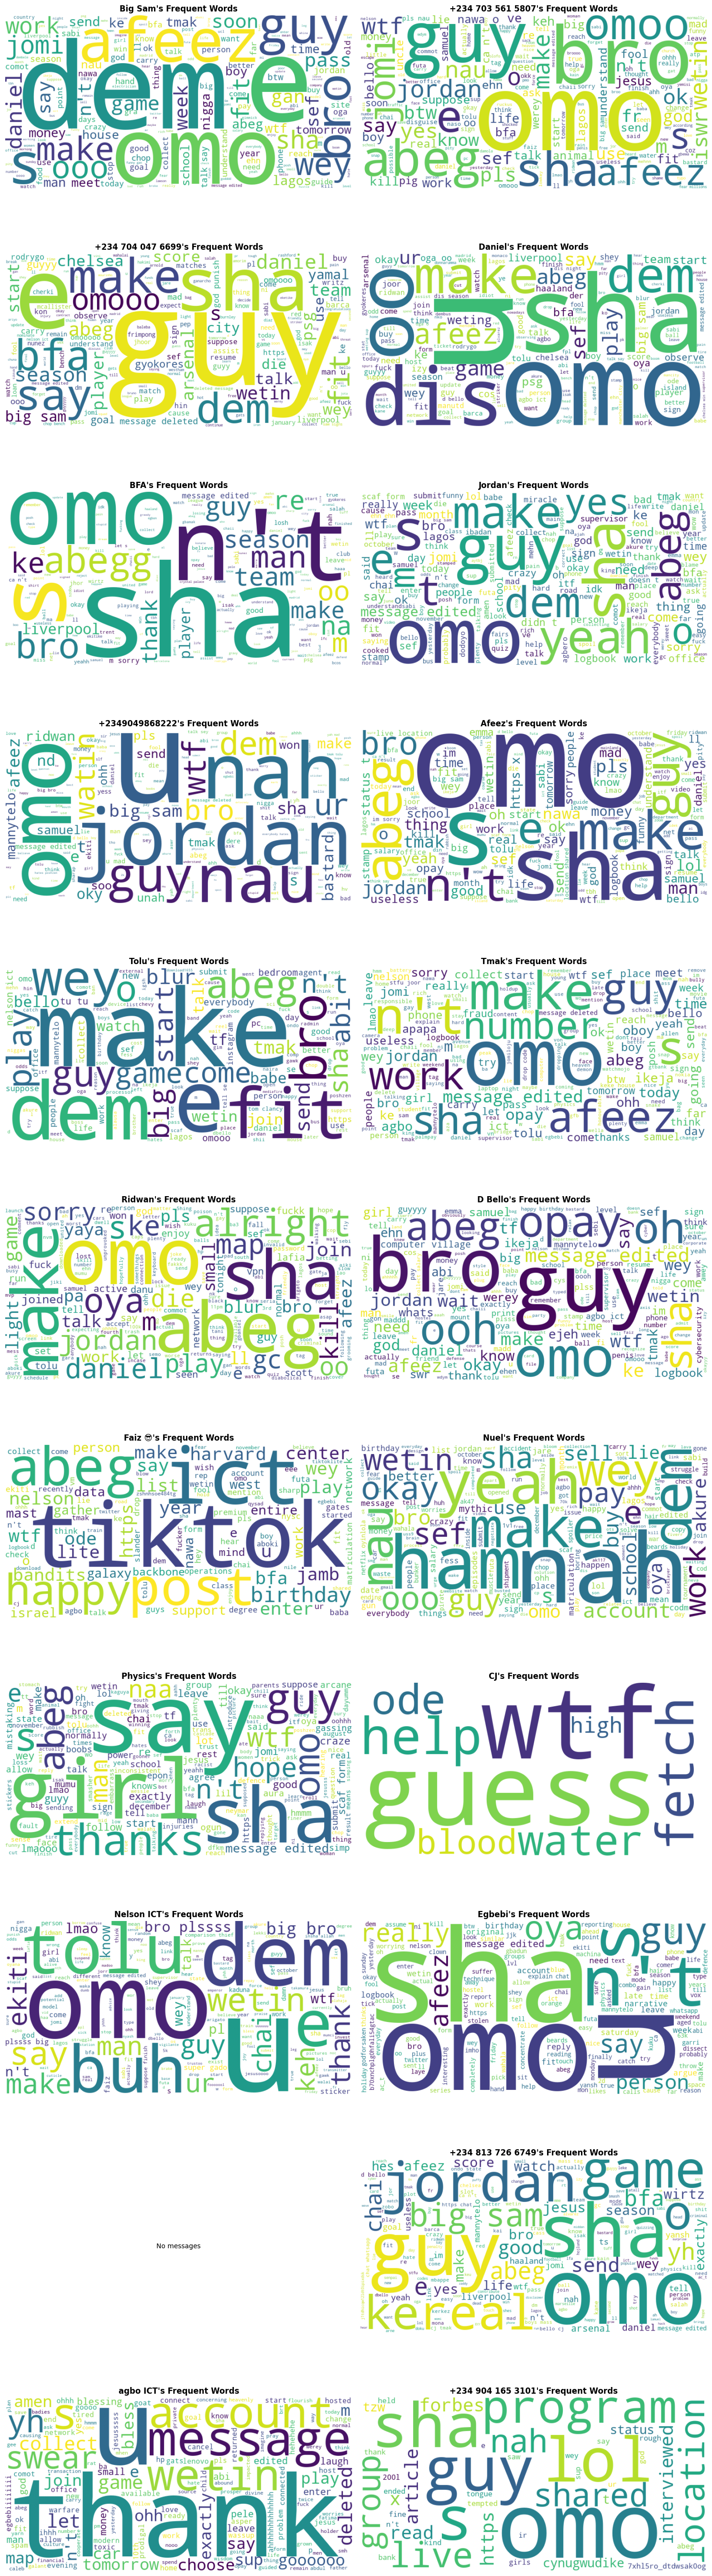

In [255]:
n_members = len(group_members)
n_cols = 2  
n_rows = math.ceil(n_members/n_cols) 
fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
ax = ax.flatten()

plt.title('Group members word cloud')
for idx, (axis, member) in enumerate(zip(ax, group_members)):
    member_texts = word_tokenize(" ".join(whatsapp_df[whatsapp_df['sender'] == member]['message'].str.lower()))
    member_texts = " ".join([t for t in member_texts if t not in ['una', 'dey', 'wan', 'na', 'don'] and t not in ENGLISH_STOP_WORDS])
    if len(member_texts) > 0:
        wordcloud = WordCloud(width=800, height=400,background_color='white', colormap='viridis').generate(member_texts)        
        axis.imshow(wordcloud, interpolation='bilinear')
        axis.set_title(f"{member}'s Frequent Words", fontsize=12, fontweight='bold')
        axis.axis('off') 
    else:
        axis.text(0.5, 0.5, 'No messages', ha='center', va='center', transform=axis.transAxes)
        axis.set_title(f"{member}", fontsize=12)
        axis.axis('off')


for j in range(len(group_members), len(ax)):
    fig.delaxes(ax[j])
plt.tight_layout()

**VaderSentiment instead of TextBlob**

In [260]:
blob = TextBlob(en_text)
blob.sentiment, blob.sentiment_assessments

(Sentiment(polarity=0.04904553100803104, subjectivity=0.5262255824130877),
 Sentiment(polarity=0.04904553100803104, subjectivity=0.5262255824130877, assessments=[(['fast'], 0.2, 0.6, None), (['fit'], 0.4, 0.4, None), (['moral'], 0.0, 0.25, None), (['idiot'], -0.8, 0.8, None), (['light'], 0.4, 0.7, None), (['light'], 0.4, 0.7, None), (['dark'], -0.15, 0.4, None), (['wtf'], -0.5, 1.0, None), (['normal'], 0.15, 0.6499999999999999, None), (['dirty'], -0.6, 0.8, None), (['real'], 0.2, 0.30000000000000004, None), (['sorry'], -0.5, 1.0, None), (['dark'], -0.15, 0.4, None), (['sweet'], 0.35, 0.65, None), (['fit'], 0.4, 0.4, None), (['light'], 0.4, 0.7, None), (['big'], 0.0, 0.1, None), (['proud'], 0.8, 1.0, None), (['actually'], 0.0, 0.1, None), (['funny'], 0.25, 1.0, None), (['rank'], -0.8, 0.9, None), (['big'], 0.0, 0.1, None), (['true'], 0.35, 0.65, None), (['ok'], 0.5, 0.5, None), (['rank'], -0.8, 0.9, None), (['low'], 0.0, 0.3, None), (['wan'], -0.2, 0.15000000000000002, None), (['chicken

In [263]:
members_sentiment_df = {}
for member in group_members:
    member_text = " ".join(whatsapp_df[whatsapp_df['sender']==member]['message'])
    member_blob= TextBlob(member_text)
    members_sentiment_df[member] = member_blob.sentiment[0]
members_sentiment_df

{'Big Sam': 0.05775499910041902,
 '+234 703 561 5807': 0.025353602365986272,
 '+234 704 047 6699': 0.08158758149017889,
 'Daniel': 0.05528245490952682,
 'BFA': 0.06491591939806231,
 'Jordan': 0.052363138117067415,
 '+2349049868222': -0.0016621491306568939,
 'Afeez': 0.07490116574828587,
 'Tolu': 0.06833012666346,
 'Tmak': 0.053037318850202284,
 'Ridwan': 0.03360719874804382,
 'D Bello': 0.06980592045247218,
 'Faiz 😎': 0.16964285714285718,
 'Nuel': 0.20837962962962966,
 'Physics': 0.2026457431457431,
 'CJ': -0.0546875,
 'Nelson ICT': 0.023252239658489656,
 'Egbebi': 0.1303661616161616,
 '': 0.0,
 '+234 813 726 6749': 0.058922558922558925,
 'agbo ICT': 0.02936117936117935,
 '+234 904 165 3101': 0.37900432900432907}

In [265]:
messages = whatsapp_df['message']
def blob_sentiment(msg):
    blob = TextBlob(msg)
    return blob.sentiment[0]
# tqdm(desc="Analyzing sentiments via textblob")
whatsapp_df['blob_polarity'] = messages.apply(blob_sentiment)

In [266]:
whatsapp_df

sender                       message       date_and_time  \
0                Big Sam                 Jomi delete 😡 2025-06-13 11:36:00   
1      +234 703 561 5807                           Omo 2025-06-13 11:37:00   
2      +234 703 561 5807     When did he post so fast? 2025-06-13 11:37:00   
3      +234 703 561 5807                             😭 2025-06-13 11:37:00   
4      +234 704 047 6699        Marin board no break?? 2025-06-13 11:55:00   
...                  ...                           ...                 ...   
14330            D Bello  Guy traffic wan wound me bro 2025-10-03 19:23:00   
14331            D Bello            Omo first time sha 2025-10-03 19:24:00   
14332           agbo ICT                          Pele 2025-10-03 19:52:00   
14333           agbo ICT            That one is normal 2025-10-03 19:53:00   
14334              Afeez                     Any game? 2025-10-04 11:08:00   

         month       day   hour        date  character_length  word_length  \
0         June    Friday  11:00  2025-06-13                13            3   
1         June    Friday  11:00  2025-06-13                 3            1   
2         June    Friday  11:00  2025-06-13                25            6   
3         June    Friday  11:00  2025-06-13                 1            1   
4         June    Friday  11:00  2025-06-13                22            4   
...        ...       ...    ...         ...               ...          ...   
14330  October    Friday  19:00  2025-10-03                28            6   
14331  October    Friday  19:00  2025-10-03                18            4   
14332  October    Friday  19:00  2025-10-03                 4            1   
14333  October    Friday  19:00  2025-10-03                18            4   
14334  October  Saturday  11:00  2025-10-04                 9            2   

      part_of_day  is_url   response_time  blob_polarity  
0         Morning   False             NaT           0.00  
1         Morning   False 0 days 00:01:00           0.00  
2         Morning   False 0 days 00:00:00           0.20  
3         Morning   False 0 days 00:00:00           0.00  
4         Morning   False 0 days 00:18:00           0.00  
...           ...     ...             ...            ...  
14330     Evening   False 0 days 00:27:00          -0.20  
14331     Evening   False 0 days 00:01:00           0.25  
14332     Evening   False 0 days 00:28:00           0.00  
14333     Evening   False 0 days 00:01:00           0.15  
14334     Morning   False 0 days 15:15:00          -0.40  

[14335 rows x 13 columns]

In [278]:
vader_analyzer = vaderSentiment.SentimentIntensityAnalyzer()
vader_analyzer.polarity_scores("I am a bit down today, but I'll keep my heads high up as I know tomorrow will definitely be better")

{'neg': 0.0, 'neu': 0.72, 'pos': 0.28, 'compound': 0.8126}

In [283]:
vader_analyzer.polarity_scores("I am down today, but I'll keep my heads high up as I know tomorrow will be better")['compound']

0.5927

In [409]:
fig = make_subplots(rows=len(freq_cols), cols=1, subplot_titles=[f"{col.capitalize()}ly Sentiment Distribution" for col in freq_cols])

for idx, col_name in enumerate(freq_cols):
    sentiment_df = whatsapp_df.groupby(col_name)['sentiment'].mean().reindex(time_order_dict[f"{col_name}_order"]).reset_index(name='count')
    trace = px.line(sentiment_df, x=col_name, y='count').data[0]
    fig.add_trace(trace, row=idx + 1,  col=1)
fig.update_layout(height=1000, title_text="Sentiment Score Distributions")
# fig.show()
# px.line(whatsapp_df.groupby('day')['sentiment'].mean().reindex(time_order_dict['day_order']))

In [410]:
member_sentiment_df = whatsapp_df.groupby('sender')['sentiment'].agg(['mean', 'std', 'median'])
px.bar(member_sentiment_df[['mean','median']].sort_values('mean', ascending=False), orientation='v')
# px.bar(member_sentiment_df['median'].sort_values(ascending=False), orientation='v')

In [414]:
sentiment_score_df = whatsapp_df.groupby('sender')['sentiment_score'].agg(['mean', 'median', 'std'])
sentiment_score_df

mean  median       std
sender                                       
                   0.000000  0.0000  0.000000
+234 703 561 5807 -0.005390  0.0000  0.266752
+234 704 047 6699  0.000655  0.0000  0.307035
+234 813 726 6749  0.041419  0.0000  0.317559
+234 904 165 3101  0.071625  0.0000  0.266962
+2349049868222    -0.033412  0.0000  0.307674
Afeez             -0.002325  0.0000  0.269498
BFA                0.045654  0.0000  0.321688
Big Sam            0.046934  0.0000  0.323767
CJ                 0.499014  0.6981  0.382698
D Bello            0.042335  0.0000  0.281097
Daniel             0.035814  0.0000  0.312653
Egbebi             0.052874  0.0000  0.310807
Faiz 😎             0.083672  0.0000  0.311521
Jordan             0.060733  0.0000  0.350227
Nelson ICT         0.010035  0.0000  0.285874
Nuel               0.052595  0.0000  0.310891
Physics            0.107608  0.0000  0.319831
Ridwan             0.049294  0.0000  0.311824
Tmak              -0.001644  0.0000  0.256314
Tolu               0.022524  0.0000  0.311212
agbo ICT           0.041539  0.0000  0.247805

In [415]:
fig =px.bar(sentiment_score_df['std'].sort_values(ascending=False), title='Group Members with most mood swings')
fig.update_layout({'xaxis_title': 'Group member', 'yaxis_title': 'Mood swing'})
fig.show()

***Most positive messages***

In [463]:
# whatsapp_df[['sender', 'message', 'date_and_time', 'day', 'sentiment']].nlargest(10, 'sentiment_score')
# whatsapp_df.drop('(sentiment, sentiment_score)', axis=1, inplace=True)
whatsapp_df
# print(hatsapp_df.nsmallest(10, 'sentiment'))

sender                       message       date_and_time  \
0                Big Sam                 Jomi delete 😡 2025-06-13 11:36:00   
1      +234 703 561 5807                           Omo 2025-06-13 11:37:00   
2      +234 703 561 5807     When did he post so fast? 2025-06-13 11:37:00   
3      +234 703 561 5807                             😭 2025-06-13 11:37:00   
4      +234 704 047 6699        Marin board no break?? 2025-06-13 11:55:00   
...                  ...                           ...                 ...   
14330            D Bello  Guy traffic wan wound me bro 2025-10-03 19:23:00   
14331            D Bello            Omo first time sha 2025-10-03 19:24:00   
14332           agbo ICT                          Pele 2025-10-03 19:52:00   
14333           agbo ICT            That one is normal 2025-10-03 19:53:00   
14334              Afeez                     Any game? 2025-10-04 11:08:00   

         month       day   hour        date  character_length  word_length  \
0         June    Friday  11:00  2025-06-13                13            3   
1         June    Friday  11:00  2025-06-13                 3            1   
2         June    Friday  11:00  2025-06-13                25            6   
3         June    Friday  11:00  2025-06-13                 1            1   
4         June    Friday  11:00  2025-06-13                22            4   
...        ...       ...    ...         ...               ...          ...   
14330  October    Friday  19:00  2025-10-03                28            6   
14331  October    Friday  19:00  2025-10-03                18            4   
14332  October    Friday  19:00  2025-10-03                 4            1   
14333  October    Friday  19:00  2025-10-03                18            4   
14334  October  Saturday  11:00  2025-10-04                 9            2   

      part_of_day  is_url   response_time  blob_polarity  sentiment  \
0         Morning   False             NaT           0.00        0.5   
1         Morning   False 0 days 00:01:00           0.00        0.5   
2         Morning   False 0 days 00:00:00           0.20        0.5   
3         Morning   False 0 days 00:00:00           0.00        0.5   
4         Morning   False 0 days 00:18:00           0.00        0.5   
...           ...     ...             ...            ...        ...   
14330     Evening   False 0 days 00:27:00          -0.20        0.5   
14331     Evening   False 0 days 00:01:00           0.25        0.5   
14332     Evening   False 0 days 00:28:00           0.00        0.5   
14333     Evening   False 0 days 00:01:00           0.15        0.5   
14334     Morning   False 0 days 15:15:00          -0.40        0.5   

      (sentiment, sentiment_score)  sentiment_score  
0                       [0.5, 0.0]           0.0000  
1                       [0.5, 0.0]           0.0000  
2                       [0.5, 0.0]           0.0000  
3                   [0.5, -0.4767]          -0.4767  
4                   [0.5, -0.3736]          -0.3736  
...                            ...              ...  
14330                   [0.5, 0.0]           0.0000  
14331                   [0.5, 0.0]           0.0000  
14332                   [0.5, 0.0]           0.0000  
14333                   [0.5, 0.0]           0.0000  
14334                   [0.5, 0.0]           0.0000  

[14335 rows x 16 columns]

***Most negative messages***

In [430]:
whatsapp_df[['sender', 'message', 'date_and_time', 'day', 'sentiment_score']].nsmallest(100, 'sentiment_score').tail()

sender                                            message  \
1714          Nelson ICT                                 U dumb as hell man   
9095             D Bello                                            Wtf 😭😭💔   
13350             Daniel  No oo dem no dey technical but for pressing an...   
8791   +234 703 561 5807                  Them dey kill am with questions 😭   
1165              Daniel                Cherki assist cold but fuck we lost   

            date_and_time        day  sentiment_score  
1714  2025-07-08 13:12:00    Tuesday          -0.8360  
9095  2025-09-22 11:39:00     Monday          -0.8360  
13350 2025-10-01 21:12:00  Wednesday          -0.8338  
8791  2025-09-17 12:50:00  Wednesday          -0.8316  
1165  2025-07-01 07:35:00    Tuesday          -0.8271

In [441]:
whatsapp_df['sentiment_score']

0        0.0000
1        0.0000
2        0.0000
3       -0.4767
4       -0.3736
          ...  
14330    0.0000
14331    0.0000
14332    0.0000
14333    0.0000
14334    0.0000
Name: sentiment_score, Length: 14335, dtype: float64

In [470]:
doc = nlp(en_text)

In [506]:
all_ent_types = list(Counter([(t.ent_type_) for t in doc if t.ent_type_ is  not ""]).keys())
all_ents_dict = {i:[] for i in all_ent_types}
[[(all_ents_dict[ent].append(t)) for t in doc if t.ent_type_ is ent] for ent in all_ent_types]
all_ents_dict

{'ORG': [jomi,
  delete,
  wan,
  dey,
  toast,
  na,
  nigeria,
  gan,
  oooo,
  oooo,
  bayern,
  𝐁𝐑𝐄𝐀𝐊𝐈𝐍𝐆,
  konaté,
  real,
  dis,
  kind,
  team,
  group,
  dey,
  madrid,
  ma,
  unah,
  sha,
  wan,
  resume,
  omooo,
  sewa,
  miracle,
  bastard,
  yess,
  sewa,
  zoro,
  zoro,
  zoro,
  almada,
  dem,
  dey,
  inter,
  milan,
  al,
  hilal,
  inter,
  milan,
  dem,
  wan,
  dis,
  yhh,
  u,
  inter,
  milan,
  inshallah,
  dfkm,
  carry,
  denzel,
  yhhhh,
  abeg,
  abeg,
  dem,
  fit,
  sha,
  rodrygo,
  x,
  diaz,
  salah,
  right,
  gakpo,
  united,
  las,
  las,
  barca,
  dey,
  arnold,
  assist,
  dembus,
  guyyyyy,
  nfu,
  egbon,
  arsenal,
  dey,
  aubameyang,
  united,
  against,
  everton,
  dis,
  season,
  dis,
  dem,
  dey,
  dey,
  liverpool,
  dey,
  mfs,
  nico,
  sef,
  ucl,
  villa,
  comot,
  ogbeni,
  bring,
  agenda,
  ucl,
  una,
  league,
  bcos,
  new,
  management,
  dembus,
  yahoo,
  dis,
  make,
  ekiti,
  dey,
  watin,
  dey,
  sup,
  school,
  dem

In [562]:
# px.pie(whatsapp_df['sender'])
member_msg_count= whatsapp_df['sender'].value_counts().rename('message_count').to_frame()
member_msg_count
fig=px.pie(member_msg_count, names=member_msg_count.index, values=member_msg_count['message_count'], hole=.1)
# fig.update_layout({'title': 'Group Members message distribution'})
fig.show()

In [512]:
datacamp\sentiment_analysis_in_python\app.py

pandas.core.series.Series

In [553]:
import streamlit as st
streamlit.write("Hello world")

2025-11-12 15:31:16.413 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-12 15:31:16.414 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-12 15:31:16.415 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [ ]:
import altairx``

In [555]:
altair?

Type:        module
String form: <module 'altair' from 'c:\\Users\\HomePC\\Desktop\\Python\\tf-env\\lib\\site-packages\\altair\\__init__.py'>
File:        c:\users\homepc\desktop\python\tf-env\lib\site-packages\altair\__init__.py
Docstring:   <no docstring>

In [564]:
import importlib
import helpers
import io
importlib.reload(helpers)



<module 'helpers' from 'c:\\Users\\HomePC\\Desktop\\Python\\Datacamp\\sentiment_analysis_in_python\\helpers.py'>

In [565]:
with ZipFile("WhatsApp Chat with The Boys.zip", "r") as f:
    f.extractall()

In [604]:
whatsapp_df['sentiment'].value_counts()

sentiment
0.5    12464
1.0     1053
0.0      818
Name: count, dtype: int64

In [ ]:
px.